# Draft `pyGIMLi(emg3d)`

**NEEDS**
- `pyGIMLi`
- `emg3d`
- `discretize`
- `xarray`
- `h5py`

**Current Limitations**
- Only isotropic models supported, without el. perm. and magn. perm.

An attempt at using `pyGIMLi` as an inversion framework for `emg3d` computations.

For developping purposes, we take a very simple grid/model/survey:
- Coarse mesh, no stretching (potentially too small).
- Simple double-halfspace model water-subsurface with a resistive block.
- Survey: A single 2D line, 6 sources, 1 frequency.

=> For this dev-implementation we also do inversion crime, using the same grid for forward modelling and inversion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d
import pygimli as pg
from pygimli.frameworks.lsqrinversion import LSQRInversion

In [2]:
%matplotlib notebook

## Load survey (incl. data), initial model, and create a Simulation

In [3]:
# obsdata = emg3d.load('pginv.h5')
inp_data = emg3d.load('pginv-coarse.h5')  # VERY COARSE (to develop)
inp_survey = inp_data['survey']
inp_model = inp_data['model']
inp_grid = inp_model.grid
inp_model

Data loaded from «/home/dtr/Codes/dev-pygimli-emg3d/pginv-coarse.h5»
[emg3d v1.8.1 (format 1.0) on 2022-12-13T18:44:55.814751].


Model: resistivity; isotropic; 32 x 16 x 16 (8,192)

In [4]:
# The model is resistivity. Change it to conductivity
# TODO: make this internally happen, so that pyGIMLi
# always gets a conductivity model!
con_model = emg3d.Model(inp_grid, 1/inp_model.property_x, mapping='Conductivity')
con_model

Model: conductivity; isotropic; 32 x 16 x 16 (8,192)

In [5]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    survey=inp_survey,
    model=con_model,
    gridding='same',  # I will like to make that more flexible in the future
    max_workers=4,    # Adjust as needed
    receiver_interpolation='linear',  # Currently necessary for the gradient
    #solver_opts={'plain': True, 'maxit': 1},  # Just for dev-purpose
    #solver_opts={'tol': 1e-4},                # Just for dev-purpose
    tqdm_opts=False,  # Switch off verbose progress bars
)

## Jacobian Wrapper (should move to a py-file)

In [6]:
class JacobianXemg3d(pg.Matrix):
    """Create a Jacobian operator to use emg3d as kernel within pyGIMLi."""
    
    def __init__(self, sim):
        super().__init__()
        self.sim = sim

    def cols(self):
        # sim.model.size corresponds to the number of cells
        return self.sim.model.size

    def rows(self):
        # sim.survey.count corresponds to the number of non-NaN data points.
        return self.sim.survey.count * 2

    def mult(self, x):
        """J * x """
        # reshape or ravel
        jvec = self.sim.jvec(np.reshape(x, self.sim.model.shape, order='F'))
        data = jvec[self.sim._finite_data]
        return np.hstack((data.real, data.imag))

    def transMult(self, x):
        """J.T * x = (x * J.T)^T """
        data = np.ones(self.sim.survey.shape, dtype=self.sim.data.observed.dtype)*np.nan
        x = np.asarray(x)
        data[self.sim._finite_data] = x[:x.size//2] + 1j*x[x.size//2:]
        return self.sim.jtvec(data).ravel('F')
    
    def save(self, *args):
        pass

## Forward Wrapper (should move to a py-file)

In [7]:
class KernelXemg3d(pg.Modelling):
    """Create a forward operator to use emg3d as kernel within pyGIMLi."""
    
    def __init__(self, sim):
        """Initialize the pyGIMLi(emg3d)-wrapper."""
        
        # Initiate first pg.Modelling, which will do its magic.
        super().__init__()
        
        # Check current limitations; PURELY for development
        # IMPROVE (implement fully or convert to checks)
        assert sim.model.case == 'isotropic'
        assert sim.model.map.name == 'Conductivity'
        
        # Add a bool to the simulation which selects all data
        # which are finite (this should go into emg3d.survey directly!)
        sim._finite_data = np.isfinite(sim.data.observed.data)
        
        # Store the simulation
        self.sim = sim
        
        # Translate discretize TensorMesh to pg-Grid
        #
        # Thomas: Do we even have to save the mesh?
        #
        self.mesh_ = pg.createGrid(
            x=sim.model.grid.nodes_x,
            y=sim.model.grid.nodes_y,
            z=sim.model.grid.nodes_z,
        )
        
        # Set the mesh properly
        self.setMesh(self.mesh_)
        
        # Define J and setJacobian
        self.J = JacobianXemg3d(sim)
        self.setJacobian(self.J)
        
        # Store obs-data and obs-error
        cplx_data = sim.data.observed.data[sim._finite_data] 
        self.obs_data = np.hstack([cplx_data.real, cplx_data.imag])

        abs_errors = sim.survey.standard_deviation.data[sim._finite_data]
        self.obs_errors = np.hstack([abs_errors, abs_errors]) / abs(self.obs_data)

    def response(self, model):
        """Create synthetic data for provided model."""
        
        # Clean emg3d-simulation, so things are recomputed
        self.sim.clean('computed')
        
        # Replace model
        self.sim.model = emg3d.Model(
            grid=self.sim.model.grid,
            property_x=model,
            mapping='Conductivity'
        )

        # Compute forward model and set initial residuals.
        _ = self.sim.misfit

        # Return the responses
        data = self.sim.data.synthetic.data[self.sim._finite_data]
        return np.hstack((data.real, data.imag))
    
    def createStartModel(self, dataVals):   # Thomas: WHY «dataVals» ??????
        """Create a start model...????"""
        # Use the model in the simulation as starting model
        # => make this more flexibel!
        return self.sim.model.property_x.ravel('F')
    
    def createJacobian(self, model):
        """Dummy to prevent pg.Modelling from doing it the hard way."""
        pass  # do nothing

## Istantiate forward and inversion instances

In [8]:
fop = KernelXemg3d(sim)


# INV = pg.Inversion(fop=fop, verbose=True, debug=True)
INV = LSQRInversion(fop=fop, verbose=True)  #, debug=True)
INV.LSQRiter = 20  # just solve lowest wavelengths
INV.transData = pg.trans.TransSymLog(sim.survey.noise_floor)
INV.transModel = pg.trans.TransLogLU(1, 1000)

## Regularization

I tried this, but to no prevail. When running the inversion it resulted in an error
```
Exception: Matrix columns do not fit right vector length!
```

## Inversion

14/12/22 - 14:20:56 - pyGIMLi - INFO - Created startmodel from forward operator: [1.         1.         1.         ... 3.33333333 3.33333333 3.33333333]
14/12/22 - 14:20:56 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 5.90887e+08/1.99923e+13
fop: <__main__.KernelXemg3d object at 0x7fcec72b34a0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7fcec72501c0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7fcec72b3770>
min/max (data): -3.4e-08/1.9e-09
min/max (error): 5%/1269%
min/max (start model): 1/3.33
--------------------------------------------------------------------------------
min/max(dweight) = 5.90887e+08/1.99923e+13
Building constraints matrix
constraint matrix of size(nBounds x nModel) 23296 x 8192
calculating jacobian matrix (forced=1)...... 0 s
min data = -3.38449e-08 max data = 1.89614e-09 (282)
min error = 0.0500037 max error = 12.6906 (282)
min response = -3.21816e-08 max response = 5.33346e-10 (282)
calc without reference model
0: rms/rrms(data, response) = 1.92923e-10/85.0843%
0: chi^2(data, response, error, log) = 8.69257
0: Phi = 2451.3 + 742.17 * 20 = 17294.7
-------------------------------------------------------------------------------

14/12/22 - 14:20:59 - pyGIMLi - INFO - 0 6.324555320336758 1.0
14/12/22 - 14:21:19 - pyGIMLi - INFO - Solution norm reached
14/12/22 - 14:21:19 - pyGIMLi - INFO - 8 8.358173754193481e-09 1.321543307134586e-09
14/12/22 - 14:21:19 - pyGIMLi - INFO - Maximum iteration reached
14/12/22 - 14:21:19 - pyGIMLi - INFO - 8 8.358173754193481e-09 1.321543307134586e-09


<IPython.core.display.Javascript object>


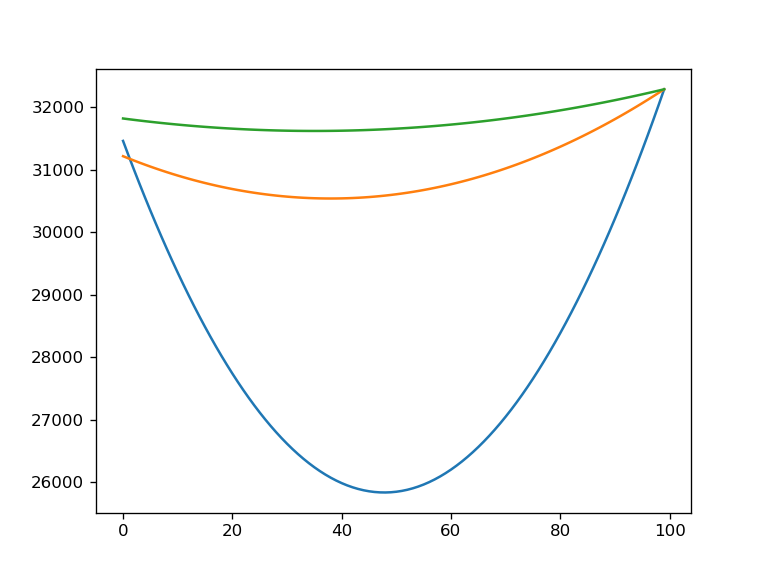

chi² = 35.13 (dPhi = 0.78%) lam: 20
--------------------------------------------------------------------------------
inv.iter 3 ... Running one inversion step!


14/12/22 - 14:21:23 - pyGIMLi - INFO - 0 6.32455532033676 1.0
14/12/22 - 14:21:40 - pyGIMLi - INFO - 10 0.00024595481086131895 3.8888870189884395e-05
14/12/22 - 14:21:48 - pyGIMLi - INFO - Solution norm reached
14/12/22 - 14:21:48 - pyGIMLi - INFO - 13 5.4322577476875675e-08 8.589153659894493e-09
14/12/22 - 14:21:48 - pyGIMLi - INFO - Maximum iteration reached
14/12/22 - 14:21:48 - pyGIMLi - INFO - 13 5.4322577476875675e-08 8.589153659894493e-09


chi² = 44.96 (dPhi = -1.93%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... Running one inversion step!


14/12/22 - 14:21:51 - pyGIMLi - INFO - 0 6.32455532033676 1.0
14/12/22 - 14:22:09 - pyGIMLi - INFO - 10 0.0010811804811241281 0.0001709496441034465
14/12/22 - 14:22:20 - pyGIMLi - INFO - Solution norm reached
14/12/22 - 14:22:20 - pyGIMLi - INFO - 15 1.3834014055796118e-08 2.1873496799549705e-09
14/12/22 - 14:22:20 - pyGIMLi - INFO - Maximum iteration reached
14/12/22 - 14:22:20 - pyGIMLi - INFO - 15 1.3834014055796118e-08 2.1873496799549705e-09


chi² = 48.74 (dPhi = -0.78%) lam: 20.0
################################################################################
#                Abort criteria reached: dPhi = -0.78 (< 2.0%)                 #
################################################################################


In [9]:
errmodel = INV.run(
    dataVals=fop.obs_data,
    errorVals=fop.obs_errors,
    #maxIter=2, # just to test
    verbose=True,
    #startModel=...,
    #isReference=True,
)

## Computed synthetic data for initial and final model

In [10]:
# Thomas: The following two things are probably already stored somewhere?

# Compute responses of the final model
sim.clean('computed')
sim.model = emg3d.Model(
    grid=sim.model.grid,
    property_x=INV.model,
    mapping='Conductivity'
)
sim.compute()

# Compute the response of the starting model for QC
sim2 = sim.copy()
sim2.clean('computed')
sim2.model = inp_data['model']
sim2.compute()

## Plots

<IPython.core.display.Javascript object>


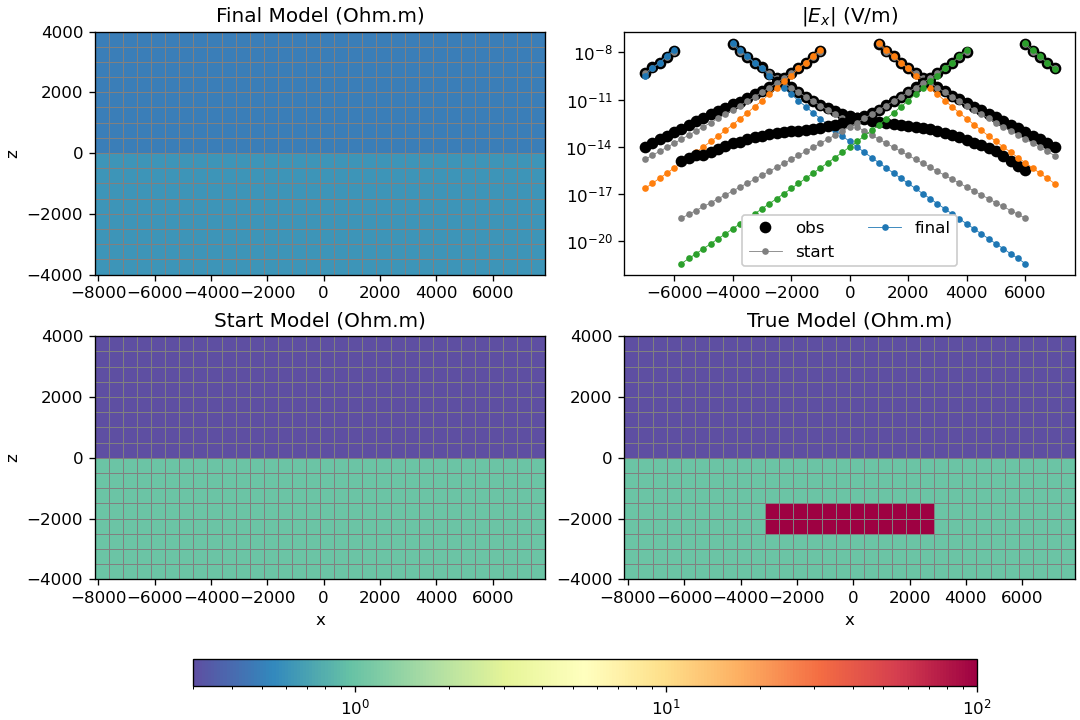

In [11]:
popts = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
opts = {'v_type': 'CC', 'normal': 'Y', 'pcolor_opts': popts}

fig, axs = plt.subplots(2, 2, figsize=(9, 6), constrained_layout=True)
(ax1, ax2), (ax3, ax4) = axs

# Final inversion model
out1, = inp_grid.plot_slice(1/np.array(INV.model), ax=ax1, **opts)
ax1.set_title(f"Final Model (Ohm.m)")
ax1.set_xlabel('')

# Start model
out3, = inp_grid.plot_slice(inp_data['model'].property_x.ravel('F'), ax=ax3, **opts)
ax3.set_title(f"Start Model (Ohm.m)")

# True model
out4, = inp_grid.plot_slice(inp_data['true_model'].property_x.ravel('F'), ax=ax4, **opts)
ax4.set_title(f"True Model (Ohm.m)")
ax4.set_ylabel('')

# Data
obs = sim.data.observed
syn = sim.data.synthetic
syn.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan
ini = sim2.data.synthetic
ini.data[~np.isfinite(obs.data)] = np.nan+1j*np.nan
rec_coords = inp_survey.receiver_coordinates()

for i, src in enumerate(inp_survey.sources.keys()):
    ax2.plot(rec_coords[0], abs(obs.loc[src, :, :].data), "ko", label='obs' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(ini.loc[src, :, :].data), ".-", c='.5', lw=0.5, label='start' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(syn.loc[src, :, :].data), f"C{i}.-", lw=0.5, label='final' if i == 0 else '')

ax2.set_yscale('log')
ax2.legend(ncol=2, framealpha=1)
ax2.set_title('$|E_x|$ (V/m)')

plt.colorbar(out1, ax=axs, orientation='horizontal', fraction=.1, shrink=.8, aspect=30);

<IPython.core.display.Javascript object>


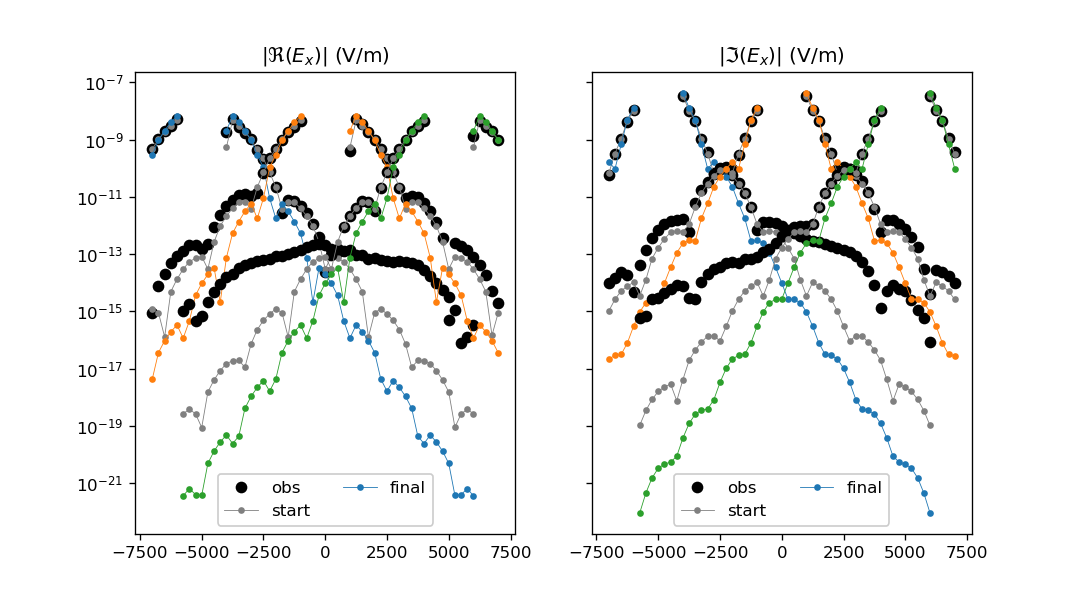

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), sharex=True, sharey=True)

for i, src in enumerate(sim.survey.sources.keys()):
    ax1.plot(rec_coords[0], abs(obs.loc[src, :, :].real), "ko", label='obs' if i == 0 else '')
    ax1.plot(rec_coords[0], abs(ini.loc[src, :, :].real), ".-", c='.5', lw=0.5, label='start' if i == 0 else '')
    ax1.plot(rec_coords[0], abs(syn.loc[src, :, :].real), f"C{i}.-", lw=0.5, label='final' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(obs.loc[src, :, :].imag), "ko", label='obs' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(ini.loc[src, :, :].imag), ".-", c='.5', lw=0.5, label='start' if i == 0 else '')
    ax2.plot(rec_coords[0], abs(syn.loc[src, :, :].imag), f"C{i}.-", lw=0.5, label='final' if i == 0 else '')

ax2.set_yscale('log')
ax1.legend(ncol=2, framealpha=1)
ax2.legend(ncol=2, framealpha=1)
ax1.set_title('$|\Re(E_x)|$ (V/m)')
ax2.set_title('$|\Im(E_x)|$ (V/m)');

In [13]:
pg.Report('emg3d')

--------------------------------------------------------------------------------
  Date: Wed Dec 14 14:22:25 2022 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 15:55:03)
  [GCC 10.4.0]

             emg3d : 1.8.0
           pygimli : 1.3.1+12.g01b7fae7 (dev)
            pgcore : Version unknown
             numpy : 1.20.3
        matplotlib : 3.5.1
             scipy : 1.9.1
              tqdm : 4.64.1
           IPython : 8.5.0
           pyvista : 0.34.2
--------------------------------------------------------------------------------

## Parking lot